# Paper 1: The First Law of Complexodynamics
## Scott Aaronson

### Implementation: Cellular Automata and Entropy Growth

This notebook demonstrates how complexity and entropy increase in closed systems using cellular automata.

In a closed system, although "entropy" (disorder) keeps increasing over time (the second law of thermodynamics), "complexity" (or "interestingness") does not.
Complexity typically follows an inverted-U curve: low at the beginning, peaking at an intermediate stage, and then declining back toward low levels.

<!-- img complexity -->
# ![complexity-dynamics](../assets/images//complexity-small.jpg)


### What is cellular automata?

A cellular automaton (CA) is a discrete dynamical system made of a grid of cells, each holding a state from a finite set (e.g., 0/1).
Time advances in discrete steps. At each step, every cell updates simultaneously according to the same local rule that depends only on its current state and the states of nearby neighbors.
Despite the simplicity of the rule, iterating it can produce rich, emergent patterns at the system level.

### Why is the cellular automata suitable for demostracting the first law of complexodynomics?

The first law of complexodynamics (as discussed by Aaronson) highlights that in closed systems, entropy tends to increase monotonically, while "complexity" or "interestingness" typically rises and then falls.
Cellular automata are ideal for demonstrating this because they are closed, fully deterministic systems with transparent, local rules.
Starting from a simple initial condition, a CA often develops structured, intricate patterns (a rise in complexity) before those structures wash out into more uniform or chaotic-looking configurations (a decline in complexity), even as entropy continues to grow.
This makes the inverted-U behavior visible without introducing hidden variables or external noise.



In [3]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)


## 1D Cellular Automaton (Rule 30 - Chaotic)

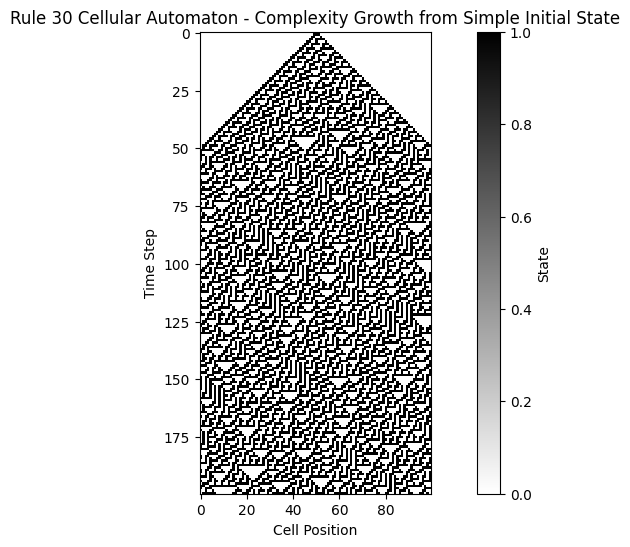

In [4]:
def rule_30(left, center, right):
    """Rule 30: Generates complex, chaotic patterns"""
    pattern = (left << 2) | (center << 1) | right
    rule = 30
    return (rule >> pattern) & 1


def evolve_ca(initial_state, steps, rule_func):
    """Evolve cellular automaton"""
    size = initial_state.numel()
    history = torch.zeros((steps, size), dtype=torch.int64)
    history[0] = initial_state

    for t in range(1, steps):
        prev = history[t - 1]
        left = torch.roll(prev, 1)
        center = prev
        right = torch.roll(prev, -1)
        history[t] = rule_func(left, center, right)

    return history


# Simple initial state
size = 100
initial = torch.zeros(size, dtype=torch.int64)
initial[size // 2] = 1  # Single cell in center

# Evolve
steps = 200
evolution = evolve_ca(initial, steps, rule_30)

plt.figure(figsize=(12, 6))
plt.imshow(evolution.numpy(), cmap='binary', interpolation='nearest')
plt.title('Rule 30 Cellular Automaton - Complexity Growth from Simple Initial State')
plt.xlabel('Cell Position')
plt.ylabel('Time Step')
plt.colorbar(label='State')
plt.show()


## Measuring Complexity Growth via Entropy

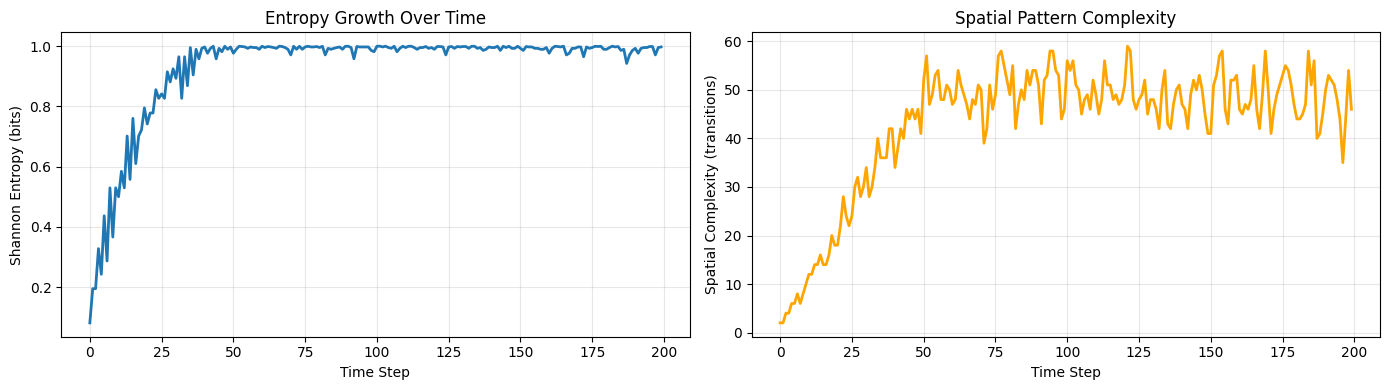

Initial Entropy: 0.0808 bits
Final Entropy: 0.9974 bits
Entropy Increase: 0.9166 bits


In [5]:
def _binary_entropy(state):
    p1 = state.float().mean()
    p0 = 1.0 - p1
    ent = 0.0
    if p0 > 0:
        ent -= p0 * torch.log2(p0)
    if p1 > 0:
        ent -= p1 * torch.log2(p1)
    return ent


def measure_entropy_over_time(history):
    """Measure Shannon entropy at each time step"""
    entropies = []

    for t in range(len(history)):
        entropies.append(_binary_entropy(history[t]))

    return torch.stack(entropies)


def measure_spatial_complexity(history):
    """Measure spatial pattern complexity (number of transitions)"""
    complexities = []

    for t in range(len(history)):
        state = history[t]
        transitions = torch.sum(torch.abs(state[1:] - state[:-1]))
        complexities.append(transitions)

    return torch.stack(complexities)


entropies = measure_entropy_over_time(evolution)
complexities = measure_spatial_complexity(evolution)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(entropies.numpy(), linewidth=2)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Shannon Entropy (bits)')
ax1.set_title('Entropy Growth Over Time')
ax1.grid(True, alpha=0.3)

ax2.plot(complexities.numpy(), linewidth=2, color='orange')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Spatial Complexity (transitions)')
ax2.set_title('Spatial Pattern Complexity')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial Entropy: {entropies[0].item():.4f} bits")
print(f"Final Entropy: {entropies[-1].item():.4f} bits")
print(f"Entropy Increase: {(entropies[-1] - entropies[0]).item():.4f} bits")


## The Coffee Automaton: Irreversible Mixing

Demonstrating that simple initial states evolve to complex patterns (like cream mixing in coffee) but the reverse is improbable.

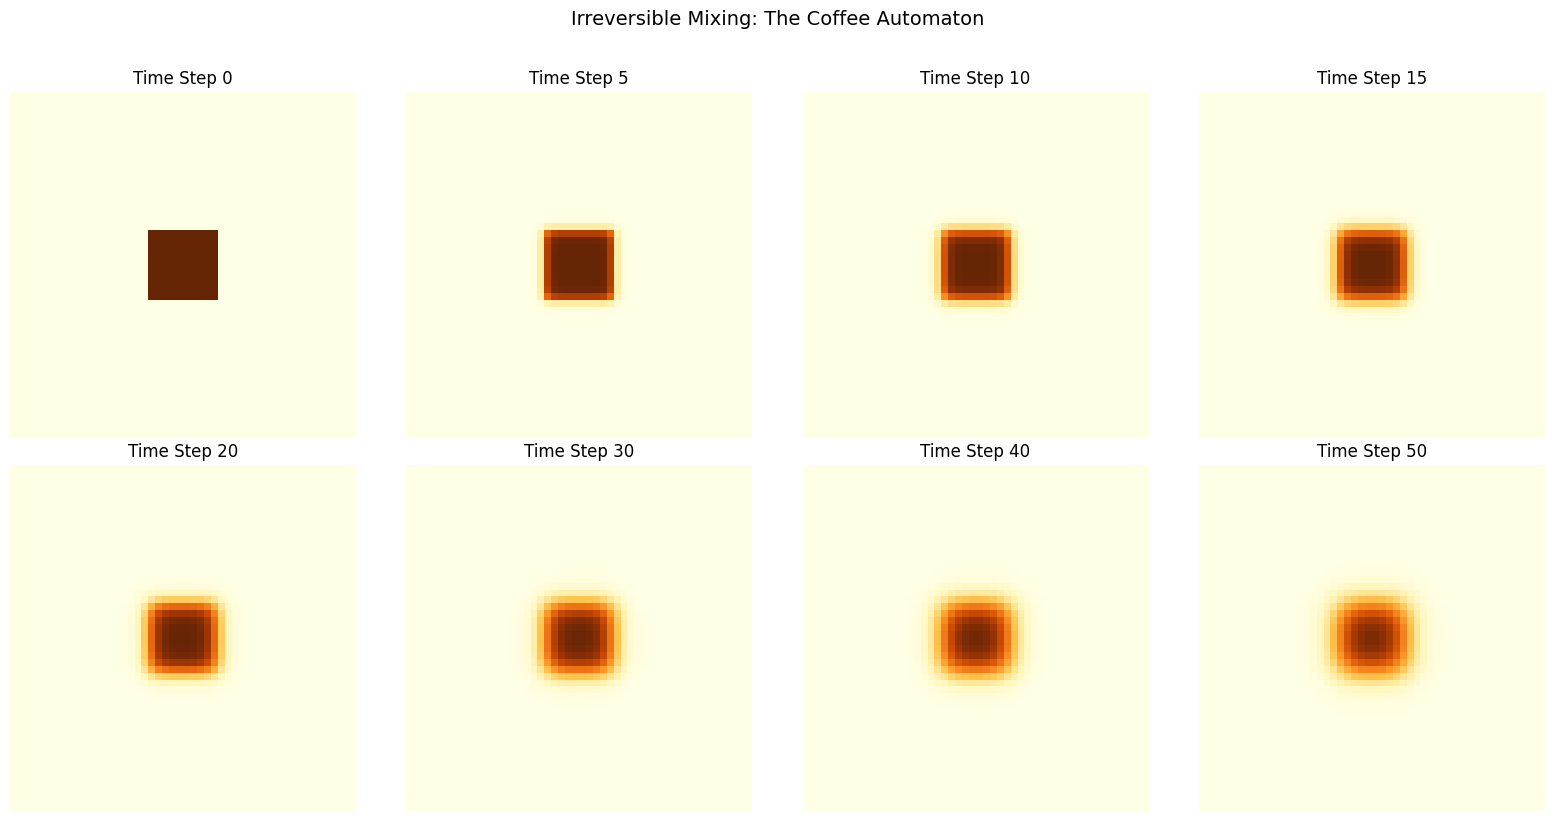

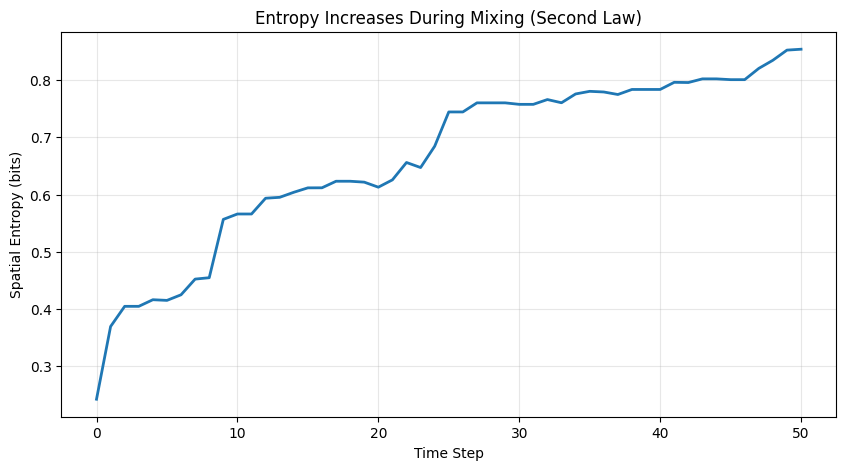


Key Insight: Simple concentrated state -> Complex mixed state
This process is irreversible: you can't unmix coffee!


In [6]:
def diffusion_2d(grid, steps, diffusion_rate=0.1):
    """Simple 2D diffusion simulation"""
    history = [grid.clone()]

    for _ in range(steps):
        new_grid = grid.clone()
        neighbors = (
            grid[:-2, 1:-1]
            + grid[2:, 1:-1]
            + grid[1:-1, :-2]
            + grid[1:-1, 2:]
        ) / 4.0
        new_grid[1:-1, 1:-1] = (
            (1 - diffusion_rate) * grid[1:-1, 1:-1]
            + diffusion_rate * neighbors
        )

        grid = new_grid
        history.append(grid.clone())

    return torch.stack(history)


# Create initial state: concentrated "cream" in coffee
size = 50
grid = torch.zeros((size, size))
grid[20:30, 20:30] = 1.0  # Concentrated region

# Simulate mixing
mixing_history = diffusion_2d(grid, steps=50, diffusion_rate=0.2)

# Visualize mixing process
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
timesteps = [0, 5, 10, 15, 20, 30, 40, 50]

for ax, t in zip(axes.flat, timesteps):
    ax.imshow(mixing_history[t].numpy(), cmap='YlOrBr', vmin=0, vmax=1)
    ax.set_title(f'Time Step {t}')
    ax.axis('off')

plt.suptitle('Irreversible Mixing: The Coffee Automaton', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Measure entropy growth in mixing
mixing_entropies = []
for t in range(len(mixing_history)):
    flat = mixing_history[t].flatten()
    bins = torch.histc(flat, bins=20, min=0.0, max=1.0)
    bins = bins[bins > 0]
    probs = bins / bins.sum()
    ent = -torch.sum(probs * torch.log2(probs))
    mixing_entropies.append(ent)

mixing_entropies = torch.stack(mixing_entropies)

plt.figure(figsize=(10, 5))
plt.plot(mixing_entropies.numpy(), linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Spatial Entropy (bits)')
plt.title('Entropy Increases During Mixing (Second Law)')
plt.grid(True, alpha=0.3)
plt.show()

print("\nKey Insight: Simple concentrated state -> Complex mixed state")
print("This process is irreversible: you can't unmix coffee!")


## Key Takeaways

1. **Complexity Growth**: Simple initial states evolve into complex patterns
2. **Entropy Increase**: Closed systems tend toward higher entropy (Second Law)
3. **Irreversibility**: Complex states are unlikely to spontaneously return to simple states
4. **Computational Irreversibility**: The Coffee Automaton demonstrates fundamental limits

This connects to deep learning through:
- Understanding of information theory
- Complexity of learned representations
- Entropy in loss functions and regularization